<div style="text-align: center">
  <img alt="AIcrowd" src="https://gitlab.aicrowd.com/jyotish/pricing-game-notebook-scripts/raw/master/pricing-game-banner.png">
</div>

# How to use this notebook 📝

1. **Copy the notebook**. This is a shared template and any edits you make here will not be saved. _You should copy it into your own drive folder._ For this, click the "File" menu (top-left), then "Save a Copy in Drive". You can edit your copy however you like.
2. **Link it to your AICrowd account**. In order to submit your code to AICrowd, you need to provide your account's API key (see [_"Configure static variables"_](#static-var) for details).
3. **Stick to the function definitions**. The submission to AICrowd will look for the pre-defined function names:
  - `fit_model`
  - `save_model`
  - `load_model`
  - `predict_expected_claim`
  - `predict_premium`

    Anything else you write outside of these functions will not be part of the final submission (including constants and utility functions), so make sure everything is defined within them, except for:
4. **Define your preprocessing**. In addition to the functions above, anything in the cell labelled [_"Define your data preprocessing"_](#data-preprocessing) will also be imported into your final submission. 

# Your pricing model 🕵️

In this notebook, you can play with the data, and define and train your pricing model. You can then directly submit it to the AICrowd, with some magic code at the end.

### Baseline logistic regression 💪
You can also play with a baseline logistic regression model [implemented here](https://colab.research.google.com/drive/1iDgDgWUw9QzOkbTYjeyY3i3DGuCoghs3?usp=sharing). 

# Setup the notebook 🛠

In [ ]:
!bash <(curl -sL https://gitlab.aicrowd.com/jyotish/pricing-game-notebook-scripts/raw/master/python/setup.sh)
from aicrowd_helpers import *

⚙️ Installing AIcrowd utilities...
  Running command git clone -q https://gitlab.aicrowd.com/yoogottamk/aicrowd-cli /tmp/pip-req-build-tt38br9g
✅ Installed AIcrowd utilities


# Configure static variables 📎
<a name="static-var"></a>

In order to submit using this notebook, you must visit this URL https://aicrowd.com/participants/me and copy your API key. 

Then you must set the value of `AICROWD_API_KEY` wuth the value.

In [ ]:
import sklearn

class Config:
    TRAINING_DATA_PATH = 'training.csv'
    MODEL_OUTPUT_PATH = 'model.pkl'
    AICROWD_API_KEY = '****5'  # You can get the key from https://aicrowd.com/participants/me
    ADDITIONAL_PACKAGES = [
        'numpy',  # you can define versions as well, numpy==0.19.2
        'pandas',
        'scikit-learn==' + sklearn.__version__,
        'catboost',
        'matplotlib',
        'seaborn'
    # NOTE THAT ANY TENSORFLOW VERSION HAS TO BE LOWER THAN 2.4. So 2.3XXX would work. 
  ]

# Download dataset files 💾

In [ ]:
# Make sure to offically join the challenge and accept the challenge rules! Otherwise you will not be able to download the data
%download_aicrowd_dataset

💾 Downloading dataset...
Verifying API Key...
API Key valid
Saved API Key successfully!
✅ Downloaded dataset


# Packages 🗃

<a name="packages"></a>

Import here all the packages you need to define your model. **You will need to include all of these packages in `Config.ADDITIONAL_PACKAGES` for your code to run properly once submitted.**

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.8MB 57kB/s 


In [ ]:
%%track_imports

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import sklearn

In [ ]:
import importlib
import global_imports
importlib.reload(global_imports)
from global_imports import *  # do not change this

# Loading the data 📲

In [ ]:
df = pd.read_csv(Config.TRAINING_DATA_PATH)
X_train = df.drop(columns=['claim_amount'])
y_train = df['claim_amount']

## How does the data look like? 🔍

Смотрим на набор признаков их значения

In [ ]:
X_train.sample(n=4)

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,drv_age1,drv_age_lic1,drv_drv2,drv_sex2,drv_age2,drv_age_lic2,vh_make_model,vh_age,vh_fuel,vh_type,vh_speed,vh_value,vh_weight,population,town_surface_area
124994,PL051186,3.0,0.000,Max,7,3,Yearly,No,Retired,M,73.0,52.0,Yes,F,67.0,41.0,lqqciehjjdtelpwa,4.0,Diesel,Tourism,184.0,35168.0,1388.0,760.0,39.5
15550,PL018075,1.0,0.369,Max,1,1,Yearly,No,WorkPrivate,M,29.0,11.0,No,0,NaN,NaN,tdgkjlphosocwbgu,3.0,Diesel,Tourism,200.0,19422.0,1315.0,470.0,47.8
82032,PL067166,2.0,0.000,Med2,12,2,Monthly,No,Retired,M,61.0,43.0,No,0,NaN,NaN,mpwepwxyokmciojj,9.0,Diesel,Commercial,131.0,18621.0,747.0,170.0,147.4
742,PL041297,1.0,0.000,Min,9,2,Yearly,No,Retired,M,58.0,38.0,Yes,F,61.0,42.0,wyqgeeclrqbihfpk,13.0,Gasoline,Tourism,138.0,10238.0,339.0,90.0,113.3


Теперь посмотрим, как выглядит целевая переменная.

In [ ]:
y_train.sample(n=4)

125781       0.00
23795     1257.41
104622       0.00
56045        0.00
Name: claim_amount, dtype: float64

In [ ]:
y_train.value_counts()

0.00       204924
1236.00       843
1242.00       399
1276.00       377
922.04        222
            ...  
4220.70         1
744.94          1
507.60          1
94.10           1
1228.79         1
Name: claim_amount, Length: 17532, dtype: int64

Статистика по датасету и далее гистограммы распределений. Здесь не отображены категориальные признаки

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,228216.0,2.500000,1.118036,1.0,1.75,2.5,3.25,4.0
pol_no_claims_discount,228216.0,0.044383,0.118354,0.0,0.00,0.0,0.00,1.0
pol_duration,228216.0,12.608651,8.638768,1.0,5.00,11.0,18.00,44.0
pol_sit_duration,228216.0,4.245049,2.622117,1.0,3.00,4.0,5.00,26.0
drv_age1,228216.0,56.339328,14.978742,19.0,45.00,56.0,67.00,104.0
drv_age_lic1,228216.0,34.132366,13.901112,1.0,24.00,34.0,44.00,80.0
drv_age2,75320.0,48.569888,16.338162,18.0,36.00,47.0,61.00,102.0
drv_age_lic2,75320.0,26.686564,14.943528,1.0,15.00,25.0,38.00,83.0
vh_age,228212.0,11.139774,7.135487,1.0,6.00,10.0,15.00,64.0
vh_speed,225664.0,170.946434,25.550016,95.0,155.00,174.0,183.00,251.0


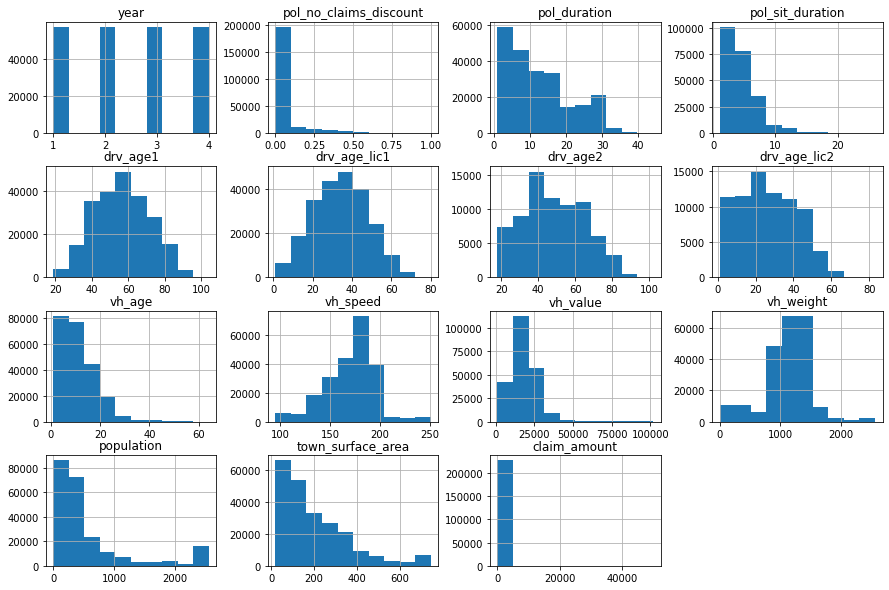

In [ ]:
df.hist(figsize=(15,10))
plt.show()

Посмотрим на типы столбцов и на наличие пропущенных значений.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228216 entries, 0 to 228215
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_policy               228216 non-null  object 
 1   year                    228216 non-null  float64
 2   pol_no_claims_discount  228216 non-null  float64
 3   pol_coverage            228216 non-null  object 
 4   pol_duration            228216 non-null  int64  
 5   pol_sit_duration        228216 non-null  int64  
 6   pol_pay_freq            228216 non-null  object 
 7   pol_payd                228216 non-null  object 
 8   pol_usage               228216 non-null  object 
 9   drv_sex1                228216 non-null  object 
 10  drv_age1                228216 non-null  float64
 11  drv_age_lic1            228216 non-null  float64
 12  drv_drv2                228216 non-null  object 
 13  drv_sex2                228216 non-null  object 
 14  drv_age2            

В следующих ячейках я преобразую категориальные столбцы в числовые методом one hot encoding, чтобы посмотреть статистику по этим данным и построить графики распределений для них.

In [ ]:
categorial_columns = ['id_policy',
                      'pol_coverage',
                      'pol_pay_freq',
                      'pol_payd',
                      'pol_usage',
                      'drv_sex1',
                      'drv_drv2',
                      'drv_sex2',
                      'vh_make_model',
                      'vh_fuel',
                      'vh_type']

In [ ]:
from sklearn.preprocessing import LabelEncoder
Encoded_dataset = df.copy()
for column in categorial_columns:
    Encoded_dataset[column] = LabelEncoder().fit_transform(Encoded_dataset[column])
Encoded_dataset

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,drv_age1,drv_age_lic1,drv_drv2,drv_sex2,drv_age2,drv_age_lic2,vh_make_model,vh_age,vh_fuel,vh_type,vh_speed,vh_value,vh_weight,population,town_surface_area,claim_amount
0,0,1.0,0.332,2,5,1,1,0,3,1,35.0,16.0,1,1,26.0,1.0,33,8.0,1,1,174.0,11040.0,1143.0,1270.0,33.1,0.0
1,25382,1.0,0.000,2,6,1,1,0,3,1,60.0,41.0,0,0,NaN,NaN,33,10.0,0,1,174.0,11040.0,1143.0,1290.0,51.3,0.0
2,25383,1.0,0.196,1,2,1,3,1,2,1,55.0,35.0,1,1,57.0,38.0,341,8.0,0,0,150.0,14159.0,1193.0,1020.0,262.8,0.0
3,25384,1.0,0.000,2,8,5,3,0,3,0,54.0,31.0,0,0,NaN,NaN,416,4.0,1,1,149.0,17233.0,1012.0,180.0,219.7,0.0
4,25385,1.0,0.000,1,2,2,3,0,2,0,65.0,38.0,0,0,NaN,NaN,709,13.0,1,1,200.0,19422.0,1315.0,30.0,70.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228211,5240,4.0,0.087,2,4,4,1,0,3,0,50.0,28.0,1,1,23.0,5.0,750,15.0,0,1,179.0,16047.0,955.0,1030.0,95.3,0.0
228212,32820,4.0,0.000,0,14,5,1,0,3,1,40.0,22.0,1,1,34.0,12.0,243,5.0,0,1,139.0,11985.0,1264.0,30.0,89.6,0.0
228213,36771,4.0,0.181,0,10,4,3,0,2,0,71.0,37.0,0,0,NaN,NaN,693,15.0,1,1,175.0,23900.0,1285.0,290.0,106.1,0.0
228214,36347,4.0,0.000,0,25,15,0,0,1,1,49.0,31.0,0,0,NaN,NaN,578,31.0,0,1,198.0,20002.0,1320.0,30.0,104.4,0.0


In [ ]:
Encoded_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_policy,228216.0,28526.500000,16470.107211,0.0,14263.00,28526.5,42790.00,57053.0
year,228216.0,2.500000,1.118036,1.0,1.75,2.5,3.25,4.0
pol_no_claims_discount,228216.0,0.044383,0.118354,0.0,0.00,0.0,0.00,1.0
pol_coverage,228216.0,0.707418,1.039069,0.0,0.00,0.0,2.00,3.0
pol_duration,228216.0,12.608651,8.638768,1.0,5.00,11.0,18.00,44.0
pol_sit_duration,228216.0,4.245049,2.622117,1.0,3.00,4.0,5.00,26.0
pol_pay_freq,228216.0,1.477679,1.256894,0.0,0.00,1.0,3.00,3.0
pol_payd,228216.0,0.041715,0.199937,0.0,0.00,0.0,0.00,1.0
pol_usage,228216.0,2.585042,0.623572,0.0,2.00,3.0,3.00,3.0
drv_sex1,228216.0,0.604112,0.489042,0.0,0.00,1.0,1.00,1.0


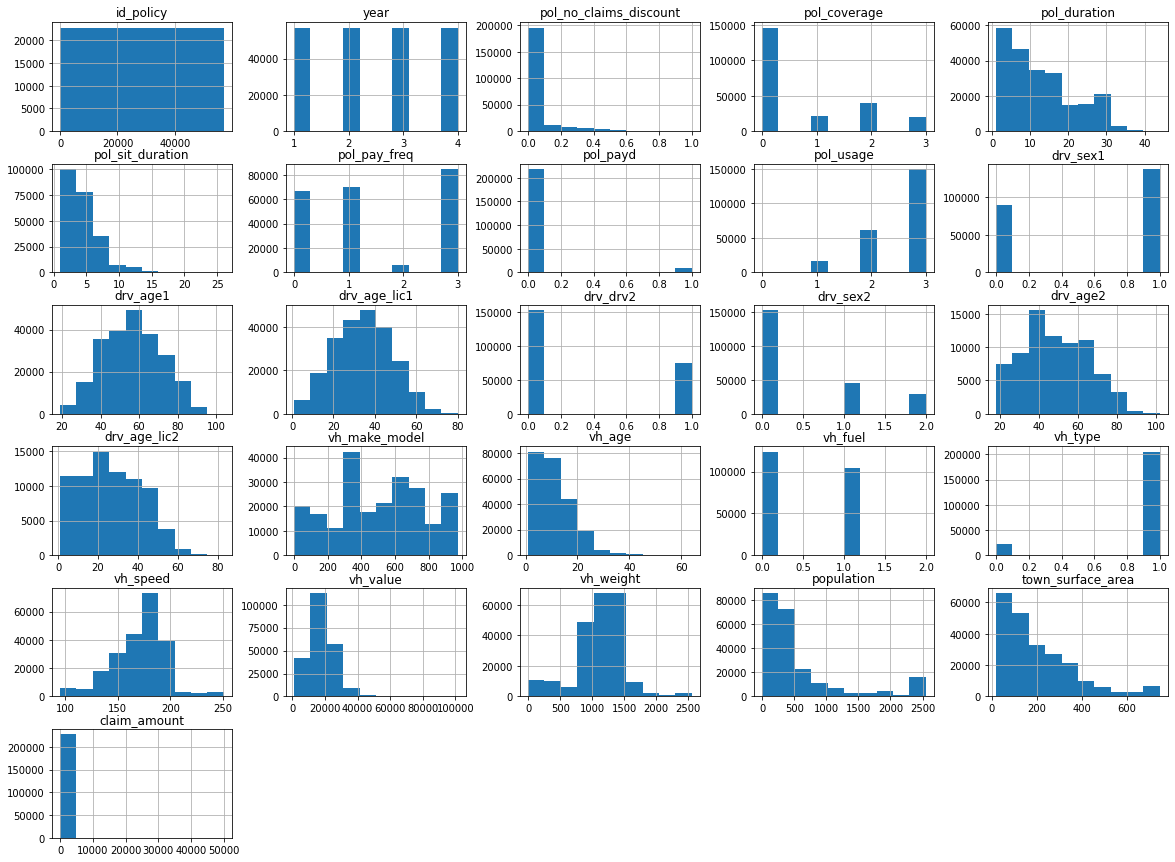

In [ ]:
Encoded_dataset.hist(figsize=(20,15))
plt.show()

Видно, что целевая переменная - claim amount - сильно несбалансирована. Какие-то признаки имеют нормальное распределение, какие-то плохо сбалансированы.
Столбцы drv_age2 и drv_age_lic2 имеют много пропущенных значений, посмотрим на значения связанного с ними столбца drv_drv2

In [ ]:
df.drv_drv2.value_counts()

No     152896
Yes     75320
Name: drv_drv2, dtype: int64

Видно, что количество значений "Yes" в этом столбце соответствует количеству значений в вышеупомянутых столбцах с пропусками. Соответственно, количество пропусков будет соответствовать значеням "No".
drv_drv2 - наличие второго водителя. Age2 и age_lic2 - его возраст и стаж вождения соответственно. Соответствие пропусков имеет логику. Но почему столбец drv_sex2 (пол второго водителя) не имеет пропусков?

In [ ]:
df.drv_sex2.value_counts()

0    152896
F     45976
M     29344
Name: drv_sex2, dtype: int64

Видим, что в датасете все эти пропуски предварительно заполнены нулями. Для наглядности нарисуем график наличия пропусков.

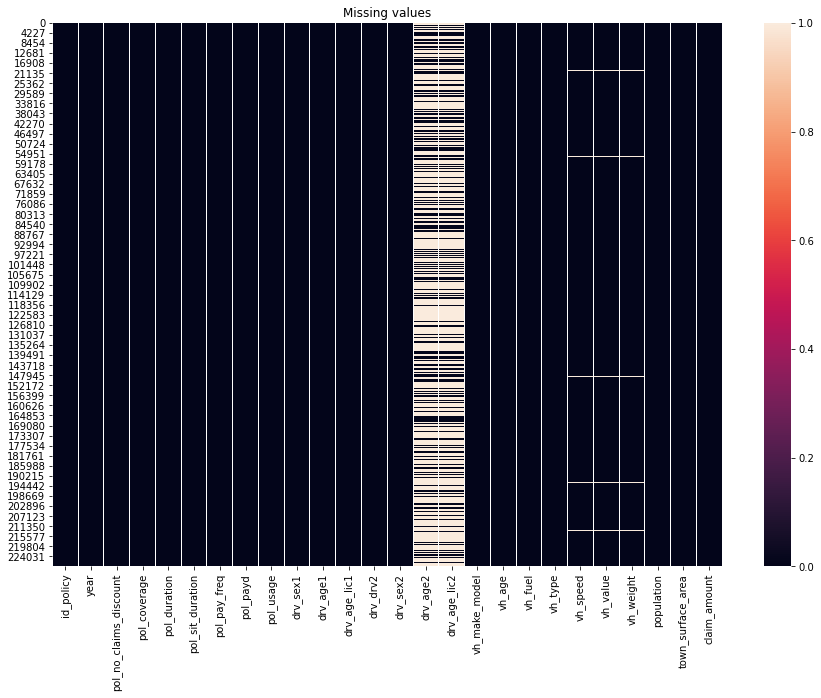

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Missing values')
sns.heatmap(df.isna())
plt.show()

Помимо указанных столбцов с большим количеством пропусков есть также незначительное количество пропусков в других столбцах. Мы с ними расправимся в разделе предобработки данных.
Пока посмотрим на корреляционную карту в нашем датасете.


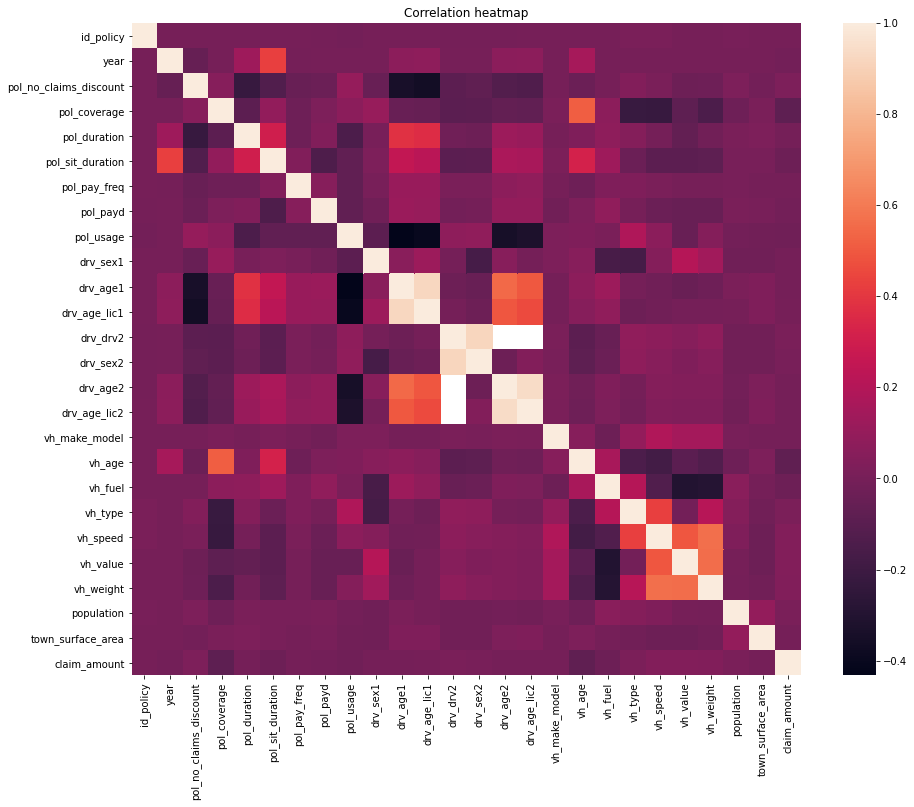

In [ ]:
plt.figure(figsize=(15,12))
plt.title('Correlation heatmap')
sns.heatmap(Encoded_dataset.corr())
plt.show()

Столбцы с пропусками сильно коррелируют между собой и столбцами drv_drv2 и drv_sex2. В таком случае их лучше удалить.

# Training the model 🚀

You must first define your first function: `fit_model`. This function takes training data as arguments, and outputs a "model" object -- that you define as you wish. For instance, this could be an array of parameter values.

## Define your data preprocessing

<a name="data-preprocessing"></a>

You can add any class or function in this cell for preprocessing. Just make sure that you use the functions here in the `fit_model`, `predict_expected_claim` and `predict_premium` functions if necessary. *italicised text*

Здесь у меня добавлены функции для предобработки данных. В качестве предобработки я решил избавиться от ненужных столбцов и удалить пропуски, а также перевести категориальные признаки в числовые с помощью LabelEncoder.

In [ ]:
%%aicrowd_include
# This magical command saves all code in this cell to a utils module.

# include your preprocessing functions and classes here. 

def delete_na(raw_X, raw_y):
    Cleaned_X = raw_X.copy()
    Cleaned_X = Cleaned_X.drop(columns = ['drv_age2', 'drv_age_lic2'])
    Cleaned_X = Cleaned_X.dropna()
    shortened_y = raw_y[Cleaned_X.index]
    return Cleaned_X, shortened_y

def encode_categorical(raw_X):
    from sklearn.preprocessing import LabelEncoder
    categorial_columns = ['id_policy',
                          'pol_coverage',
                          'pol_pay_freq',
                          'pol_payd',
                          'pol_usage',
                          'drv_sex1',
                          'drv_drv2',
                          'drv_sex2',
                          'vh_make_model',
                          'vh_fuel',
                          'vh_type']
    for column in categorial_columns:
        raw_X[column] = LabelEncoder().fit_transform(raw_X[column])
    return raw_X

In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import *  # do not change this

## Define the training logic

В этой функции я инициализировал модель с нужными мне параметрами, а также добавил функции предобработки данных, таким образом, могу подавать в эту функцию "сырые" данные. 

In [ ]:
def fit_model(X_raw, y_raw):
    """Model training function: given training data (X_raw, y_raw), train this pricing model.

    Parameters
    ----------
    X_raw : Pandas dataframe, with the columns described in the data dictionary.
        Each row is a different contract. This data has not been processed.
    y_raw : a Numpy array, with the value of the claims, in the same order as contracts in X_raw.
        A one dimensional array, with values either 0 (most entries) or >0.

    Returns
    -------
    self: this instance of the fitted model. This can be anything, as long as it is compatible
        with your prediction methods.

    """

    # TODO: train your model here.
    # Don't forget any preprocessing of the raw data here
    
    Cleaned_X, fitted_y = delete_na(X_raw, y_raw)
    Encoded_X = encode_categorical(Cleaned_X)
   
    model = catboost.CatBoostRegressor(iterations = 40, learning_rate = 0.25)
    model.fit(Encoded_X, fitted_y)
    return model

## Train your model

Следующая ячейка мне необходима для валидации модели и проверки её показателей на имеющихся данных (реальная тестовая часть в соревновании мне недоступна).

In [ ]:

from sklearn import metrics
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X_train, y_train)
testing_model = fit_model(train_X, train_y)
test_X, test_y = delete_na(test_X, test_y)
test_X = encode_categorical(test_X)
test_preds = testing_model.predict(test_X)
print('Показатель метрики RMSE: ', sklearn.metrics.mean_squared_error(test_y, test_preds, squared=False))
print('Показатель метрики MAE: ',sklearn.metrics.mean_absolute_error(test_y, test_preds))


0:	learn: 588.0048640	total: 38.1ms	remaining: 1.49s
1:	learn: 586.9885304	total: 74.6ms	remaining: 1.42s
2:	learn: 586.3324024	total: 113ms	remaining: 1.4s
3:	learn: 585.8913653	total: 143ms	remaining: 1.29s
4:	learn: 585.6021771	total: 176ms	remaining: 1.23s
5:	learn: 585.3660876	total: 206ms	remaining: 1.17s
6:	learn: 584.7512258	total: 238ms	remaining: 1.12s
7:	learn: 584.4623046	total: 272ms	remaining: 1.09s
8:	learn: 584.3357246	total: 307ms	remaining: 1.06s
9:	learn: 583.8804487	total: 336ms	remaining: 1.01s
10:	learn: 583.7363749	total: 367ms	remaining: 969ms
11:	learn: 583.6742681	total: 398ms	remaining: 928ms
12:	learn: 582.4969721	total: 427ms	remaining: 886ms
13:	learn: 581.9056061	total: 459ms	remaining: 853ms
14:	learn: 581.8342800	total: 493ms	remaining: 822ms
15:	learn: 580.2759806	total: 525ms	remaining: 787ms
16:	learn: 580.1573359	total: 552ms	remaining: 747ms
17:	learn: 580.0037710	total: 583ms	remaining: 712ms
18:	learn: 579.9079218	total: 611ms	remaining: 675ms
19

Здесь я проверяю важность признаков для обучения модели. Они значительно менялись при изменении параметров модели.

In [ ]:
testing_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,town_surface_area,11.017798
1,vh_age,10.909734
2,vh_make_model,10.372078
3,drv_age1,7.922037
4,id_policy,6.874892
5,vh_value,6.580443
6,pol_no_claims_discount,5.753852
7,population,5.685327
8,drv_age_lic1,4.696914
9,pol_coverage,4.566442


В следующей ячейке я перебирал различные параметры для итоговой модели. Это был очень долгий процесс, который повторялся несколько раз с различными вариациями параметров. Стоить отметить, что количество итераций последних моделей значительно ниже значения по умолчанию, скорость обучения несколько выше.

In [ ]:
'''
Kitty = catboost.CatBoostRegressor(iterations = 30,)
Kitty_search = Kitty.grid_search(param_grid={'learning_rate': np.linspace(0.01,0.45,45)}, 
                                 X=X_train, 
                                 y=y_train,
                                 plot = True)
Kitty_search
'''

Ниже я вызываю функцию для обучения модели.

In [ ]:
trained_model = fit_model(X_train, y_train)

0:	learn: 582.6754057	total: 99.1ms	remaining: 3.86s
1:	learn: 581.8598362	total: 145ms	remaining: 2.75s
2:	learn: 581.2648741	total: 186ms	remaining: 2.3s
3:	learn: 580.3270103	total: 226ms	remaining: 2.04s
4:	learn: 580.0967463	total: 268ms	remaining: 1.88s
5:	learn: 579.5191638	total: 315ms	remaining: 1.78s
6:	learn: 579.3261440	total: 356ms	remaining: 1.68s
7:	learn: 579.2156365	total: 394ms	remaining: 1.58s
8:	learn: 579.1073317	total: 433ms	remaining: 1.49s
9:	learn: 579.0017168	total: 474ms	remaining: 1.42s
10:	learn: 578.9221080	total: 512ms	remaining: 1.35s
11:	learn: 578.7772057	total: 558ms	remaining: 1.3s
12:	learn: 578.6899024	total: 602ms	remaining: 1.25s
13:	learn: 578.5725854	total: 648ms	remaining: 1.2s
14:	learn: 578.4653563	total: 694ms	remaining: 1.16s
15:	learn: 578.4013657	total: 739ms	remaining: 1.11s
16:	learn: 578.3415146	total: 787ms	remaining: 1.06s
17:	learn: 577.6999517	total: 823ms	remaining: 1.01s
18:	learn: 577.6346987	total: 864ms	remaining: 955ms
19:	l

**Important note**: your training code should be able to run in under 10 minutes (since this notebook is re-run entirely on the server side). 

If you run into an issue here we recommend using the *zip file submission* (see the [challenge page](https://www.aicrowd.com/challenges/insurance-pricing-game/#how-to%20submit)). In short, you can simply do this by copy-pasting your `fit_model`, `predict_expected_claim` and `predict_premium` functions to the `model.py` file.

Note that if you want to perform extensive cross-validation/hyper-parameter selection, it is better to do them offline, in a separate notebook.

## Saving your model

You can save your model to a file here, so you don't need to retrain it every time.

In [ ]:
def save_model(model_path):  # some models such xgboost models or keras models don't pickle very reliably. Please use the package provided saving functions instead. 
  with open(model_path, 'wb') as target_file:
      pickle.dump(trained_model, target_file)

In [ ]:
save_model(Config.MODEL_OUTPUT_PATH)

If you need to load it from file, you can use this code:

In [ ]:
def load_model(model_path): # some models such xgboost models or keras models don't pickle very reliably. Please use the package provided saving functions instead. 
  with open(model_path, 'rb') as target:
      return pickle.load(target)

In [ ]:
trained_model = load_model(Config.MODEL_OUTPUT_PATH)

# Predicting the claims 💵

The second function, `predict_expected_claim`, takes your trained model and a dataframe of contracts, and outputs a prediction for the (expected) claim incurred by each contract. This expected claim can be seen as the probability of an accident multiplied by the cost of that accident.

This is the function used to compute the _RMSE_ leaderboard, where the model best able to predict claims wins.

In [ ]:
def predict_expected_claim(model, X_raw):
    """Model prediction function: predicts the expected claim based on the pricing model.

    This functions estimates the expected claim made by a contract (typically, as the product
    of the probability of having a claim multiplied by the expected cost of a claim if it occurs),
    for each contract in the dataset X_raw.

    This is the function used in the RMSE leaderboard, and hence the output should be as close
    as possible to the expected cost of a contract.

    Parameters
    ----------
    model: a Python object that describes your model. This can be anything, as long
        as it is consistent with what `fit` outpurs.
    X_raw : Pandas dataframe, with the columns described in the data dictionary.
        Each row is a different contract. This data has not been processed.

    Returns
    -------
    avg_claims: a one-dimensional Numpy array of the same length as X_raw, with one
        expected claim per contract (in same order). These expected claims must be POSITIVE (>0).
    """

    # TODO: estimate the expected claim of every contract.
    # Don't forget any preprocessing of the raw data here

    encoded_X = encode_categorical(X_raw)

    predictions = model.predict(encoded_X)
    return predictions

To test your function, run it on your training data:

In [ ]:
predict_expected_claim(trained_model, X_train)

array([121.95538482,  75.484131  ,  98.57413975, ..., 168.32001396,
        93.95178955, 137.45903624])

# Pricing contracts 💰💰

The third and final function, `predict_premium`, takes your trained model and a dataframe of contracts, and outputs a _price_ for each of these contracts. **You are free to set this prices however you want!** These prices will then be used in competition with other models: contracts will choose the model offering the lowest price, and this model will have to pay the cost if an accident occurs.

This is the function used to compute the _profit_ leaderboard: your model will participate in many markets of size 10, populated by other participants' model, and we compute the average profit of your model over all the markets it participated in.

In [ ]:
def predict_premium(model, X_raw):
    """Model prediction function: predicts premiums based on the pricing model.

    This function outputs the prices that will be offered to the contracts in X_raw.
    premium will typically depend on the average claim predicted in 
    predict_average_claim, and will add some pricing strategy on top.

    This is the function used in the average profit leaderboard. Prices output here will
    be used in competition with other models, so feel free to use a pricing strategy.

    Parameters
    ----------
    model: a Python object that describes your model. This can be anything, as long
        as it is consistent with what `fit` outpurs.
    X_raw : Pandas dataframe, with the columns described in the data dictionary.
        Each row is a different contract. This data has not been processed.

    Returns
    -------
    prices: a one-dimensional Numpy array of the same length as X_raw, with one
        price per contract (in same order). These prices must be POSITIVE (>0).
    """

    # TODO: return a price for everyone.
    # Don't forget any preprocessing of the raw data here

    encoded_X = encode_categorical(X_raw)

    Claims = predict_expected_claim(model,encoded_X)
    Claims[Claims < 1] = 1 
    return Claims * 1.05

To test your function, run it on your training data.

In [ ]:
prices = predict_premium(trained_model, X_train)

#### Profit on training data

In order for your model to be considered in the profit competition, it needs to make nonnegative profit over its training set. You can check that your model satisfies this condition below:

In [ ]:
print('Income:', prices.sum())
print('Losses:', y_train.sum())

if prices.sum() < y_train.sum():
    print('Your model loses money on the training data! It does not satisfy market rule 1: Non-negative training profit.')
    print('This model will be disqualified from the weekly profit leaderboard, but can be submitted for educational purposes to the RMSE leaderboard.')
else:
    print('Your model passes the non-negative training profit test!')

Income: 27492402.692738637
Losses: 25809734.920000006
Your model passes the non-negative training profit test!


# Ready? Submit to AIcrowd 🚀

If you are satisfied with your code, run the code below to send your code to the AICrowd servers for evaluation! This requires the variable `trained_model` to be defined by your previous code.

**Make sure you have included all packages needed to run your code in the [_"Packages"_](#packages) section.**

**NOTE**: If you submit the baseline RMSE model without any change whatsoever, your model will not be entered into the market. 

In [ ]:
%aicrowd_submit

🚀 Preparing to submit...
⚙️ Collecting the submission code...
💾 Preparing the submission zip file...
adding: predict_expected_claim.py (deflated 52%)
adding: save_model.py (deflated 37%)
adding: config.json (deflated 8%)
adding: fit_model.py (deflated 48%)
adding: predict.py (deflated 52%)
adding: global_imports.py (deflated 38%)
adding: requirements.txt (deflated 4%)
adding: predict_premium.py (deflated 52%)
adding: utils.py (deflated 60%)
adding: model.pkl (deflated 47%)
adding: load_model.py (deflated 35%)
Verifying API Key...
API Key valid
Saved API Key successfully!
╭─────────────────────────╮
│ Successfully submitted! │
╰─────────────────────────╯
Important links
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/insurance-pricing-game/submissions/120984              │
│                  │                                                                            